# Extrapolation method for stress result of a 3D element {#extrapolation_test_stress_3Delement}

This example shows how to compute the stress nodal components from
Gaussian points (integration points) for a 3D element using
extrapolation.

Extrapolate results available at Gaussian or quadrature points to nodal
points for a field or fields container. The available elements are:

-   Linear quadrangle
-   Parabolic quadrangle
-   Linear hexagonal
-   Quadratic hexagonal
-   Linear tetrahedral
-   Quadratic tetrahedral

Here are the steps for extrapolation:

1.  Get the data source\'s solution from the integration points. (This
    result file was generated with the Ansys Mechanical APDL (MAPDL)
    option `ERESX, NO`).
2.  Use the extrapolation operator to compute the nodal stress.
3.  Get the result for nodal stress from the data source. The analysis
    was computed by MAPDL.
4.  Compare the result for nodal stress from the data source and the
    nodal stress computed by the extrapolation method.


In [1]:
from ansys.dpf import core as dpf
from ansys.dpf.core import examples

Get the data source\'s analysis of integration points and analysis
reference


In [2]:
datafile = examples.download_extrapolation_3d_result()

# Get integration points (Gaussian points)
data_integration_points = datafile["file_integrated"]
data_sources_integration_points = dpf.DataSources(data_integration_points)

# Get the reference
dataSourceref = datafile["file_ref"]
data_sources_ref = dpf.DataSources(dataSourceref)

# Get the mesh
model = dpf.Model(data_integration_points)
mesh = model.metadata.meshed_region

# Operator instantiation scoping
op_scoping = dpf.operators.scoping.split_on_property_type()  # operator instantiation
op_scoping.inputs.mesh.connect(mesh)
op_scoping.inputs.requested_location.connect("Elemental")
mesh_scoping = op_scoping.outputs.mesh_scoping()

# Extrapolate from integration points for stress result

This example uses the `gauss_to_node_fc` operator to compute the nodal
component stress result from the stress result of integration points.


In [3]:
# Create stress operator to get stress result of integration points
stressop = dpf.operators.result.stress()
stressop.inputs.data_sources.connect(data_sources_integration_points)
stress = stressop.outputs.fields_container()

# Nodal stress result of integration points

> The MAPLD command `ERESX,NO` is used to copy directly the Gaussian
> (integration) points results to the nodes, instead of the results at
> nodes or elements (which are interpolation of results at a few gauss
> points). The following plot shows the nodal values, which are the
> averaged values of stresses at each node. The value shown at the node
> is the average of the stresses from the Gaussian points of each
> element that it belongs to.


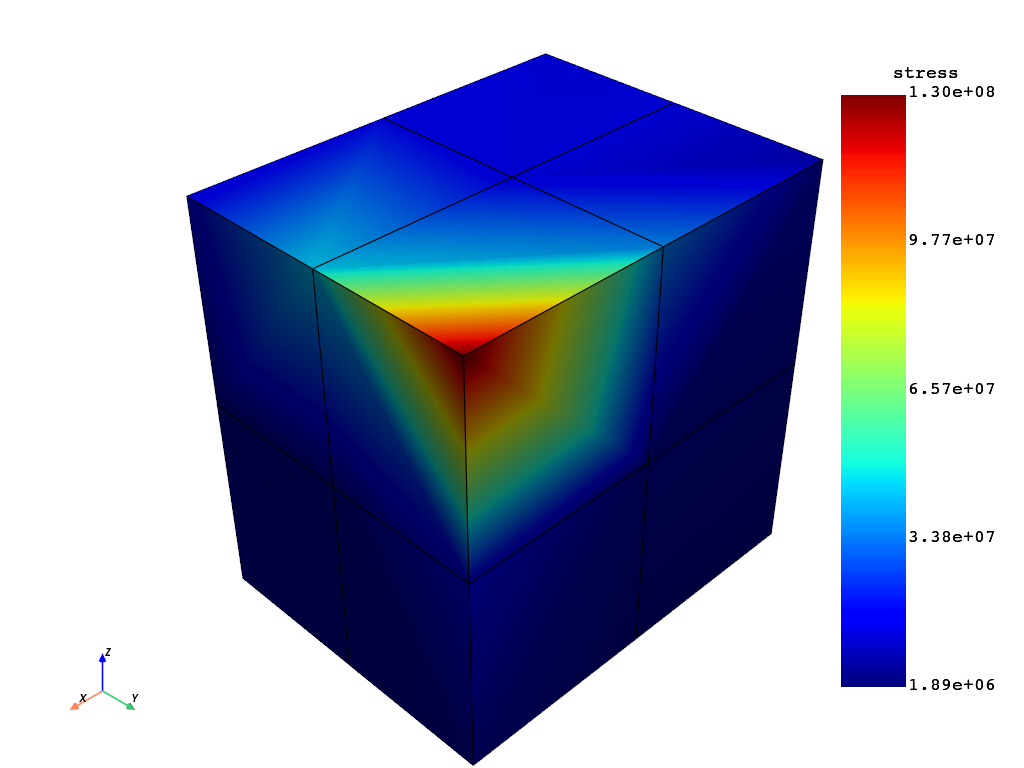

In [4]:
# Plot
stress_nodal_op = dpf.operators.averaging.elemental_nodal_to_nodal_fc()
stress_nodal_op.inputs.fields_container.connect(stress)
mesh.plot(stress_nodal_op.outputs.fields_container())

Create operator `gauss_to_node_fc` and compute nodal component stress by
applying the extrapolation method.


In [5]:
ex_stress = dpf.operators.averaging.gauss_to_node_fc()
# connect mesh
ex_stress.inputs.mesh.connect(mesh)
# connect fields container stress
ex_stress.inputs.fields_container.connect(stress)
# get output
fex = ex_stress.outputs.fields_container()

# Stress result of reference Ansys Workbench


In [6]:
# Stress from file dataSourceref
stressop_ref = dpf.operators.result.stress()
stressop_ref.inputs.data_sources.connect(data_sources_ref)
stressop_ref.inputs.mesh_scoping.connect(mesh_scoping)
stress_ref = stressop_ref.outputs.fields_container()

# Plot

Show plots of the extrapolation\'s stress result and the reference\'s
stress result


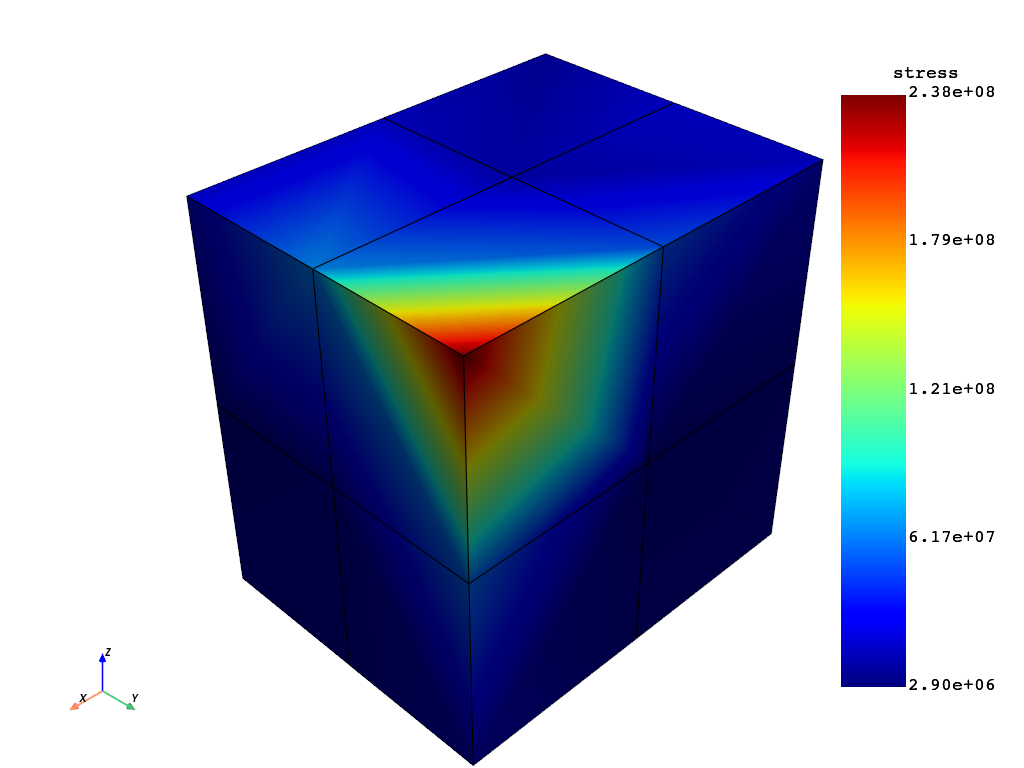

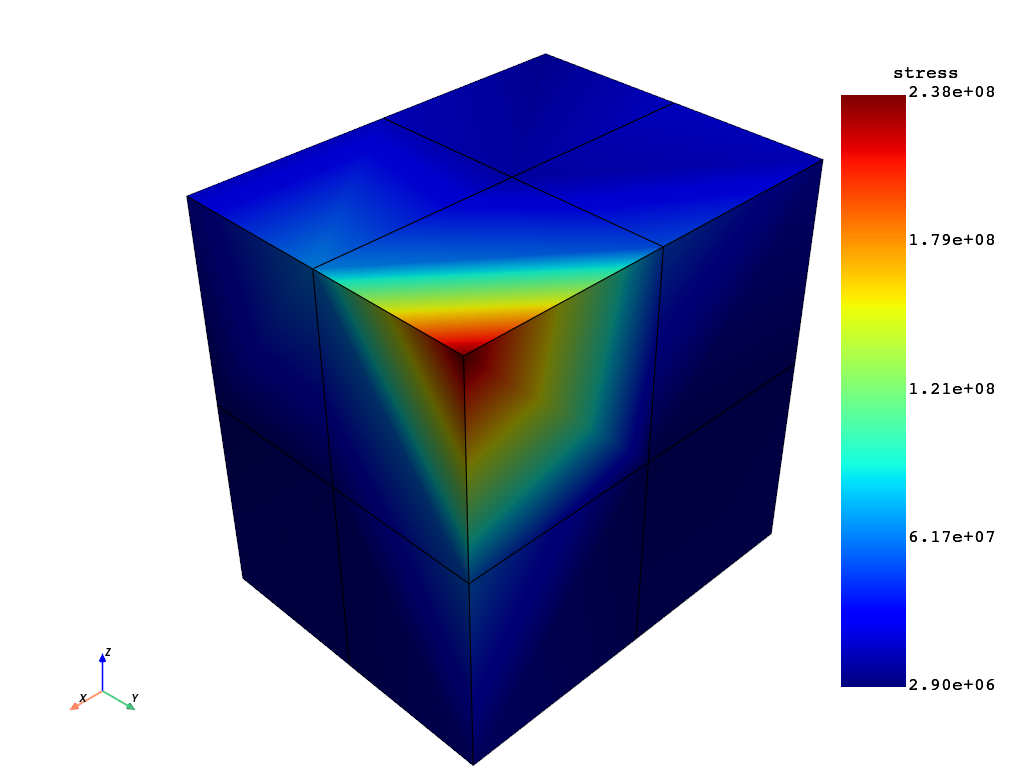

In [7]:
# extrapolation
fex_nodal_op = dpf.operators.averaging.elemental_nodal_to_nodal_fc()
fex_nodal_op.inputs.fields_container.connect(fex)
fex_nodal_fc = fex_nodal_op.eval()
mesh.plot(fex_nodal_fc)

# reference
stress_ref_nodal_op = dpf.operators.averaging.elemental_nodal_to_nodal_fc()
stress_ref_nodal_op.inputs.fields_container.connect(stress_ref)
stress_ref_nodal_fc = stress_ref_nodal_op.eval()
mesh.plot(stress_ref_nodal_fc)

# Compare stress results

Compare the stress result computed by extrapolation and the reference\'s
result. Check if the two fields container are identical using the
`identical_fc <ansys.dpf.core.operators.logic.identical_fc>`{.interpreted-text
role="class"} operator. The relative tolerance is set to 1.1e-6. The
smallest value that is considered during the comparison step: all the
`abs(values)` in field less than 1e-2 is considered as null.


In [8]:
# operator AreFieldsIdentical_fc
op = dpf.operators.logic.identical_fc()
op.inputs.fields_containerA.connect(fex_nodal_op)
op.inputs.fields_containerB.connect(stress_ref_nodal_op)
op.inputs.tolerance.connect(1.1e-6)
op.inputs.small_value.connect(0.01)
op.outputs.boolean()

True

Compute absolute and relative errors


In [9]:
abs_error_sqr = dpf.operators.math.sqr_fc()
abs_error = dpf.operators.math.sqrt_fc()
error = stress_ref_nodal_op - fex_nodal_op
abs_error_sqr.inputs.fields_container.connect(error)
abs_error.inputs.fields_container.connect(abs_error_sqr)


divide = dpf.operators.math.component_wise_divide()
divide.inputs.fieldA.connect(stress_ref_nodal_op - fex_nodal_op)
divide.inputs.fieldB.connect(stress_ref_nodal_op)
rel_error = dpf.operators.math.scale()
rel_error.inputs.field.connect(divide)
rel_error.inputs.ponderation.connect(1.0)

Plot absolute and relative errors. The absolute value is the order of
10, which is very small when compared to the magnitude of 1e8 of the
displacements. This is reflected in the relative error plot, where the
errors are found to be below 1.02e-6%. The result of these plots can be
used to set the tolerances for the
`identical_fc <ansys.dpf.core.operators.logic.identical_fc>`{.interpreted-text
role="class"} operator.


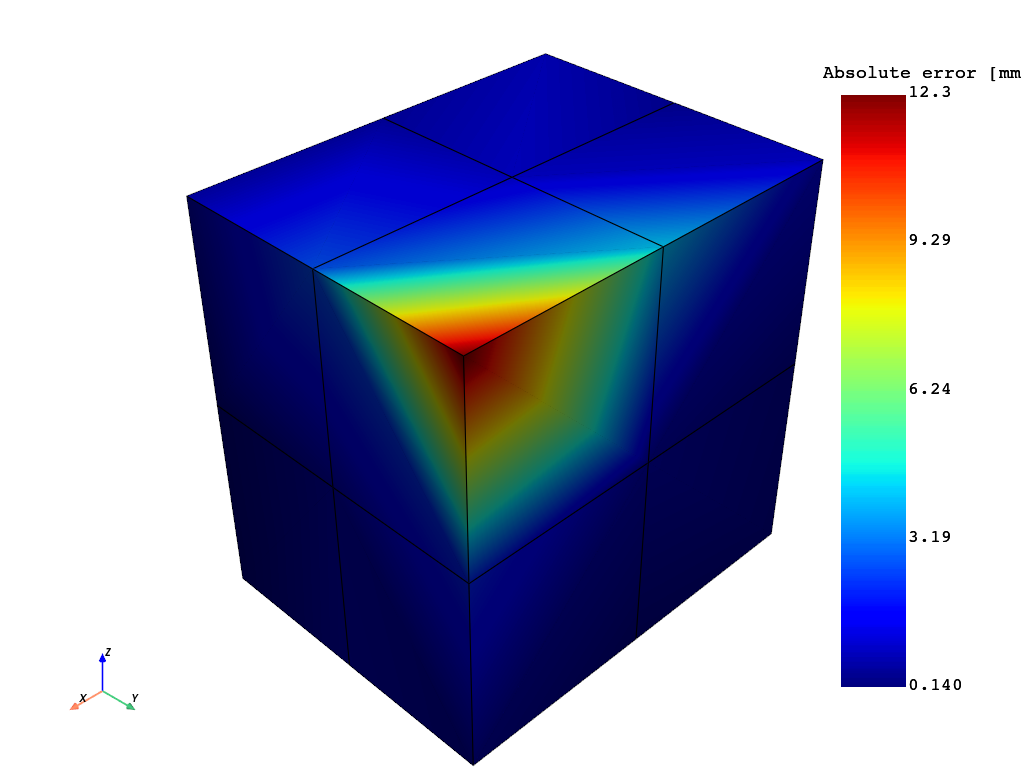

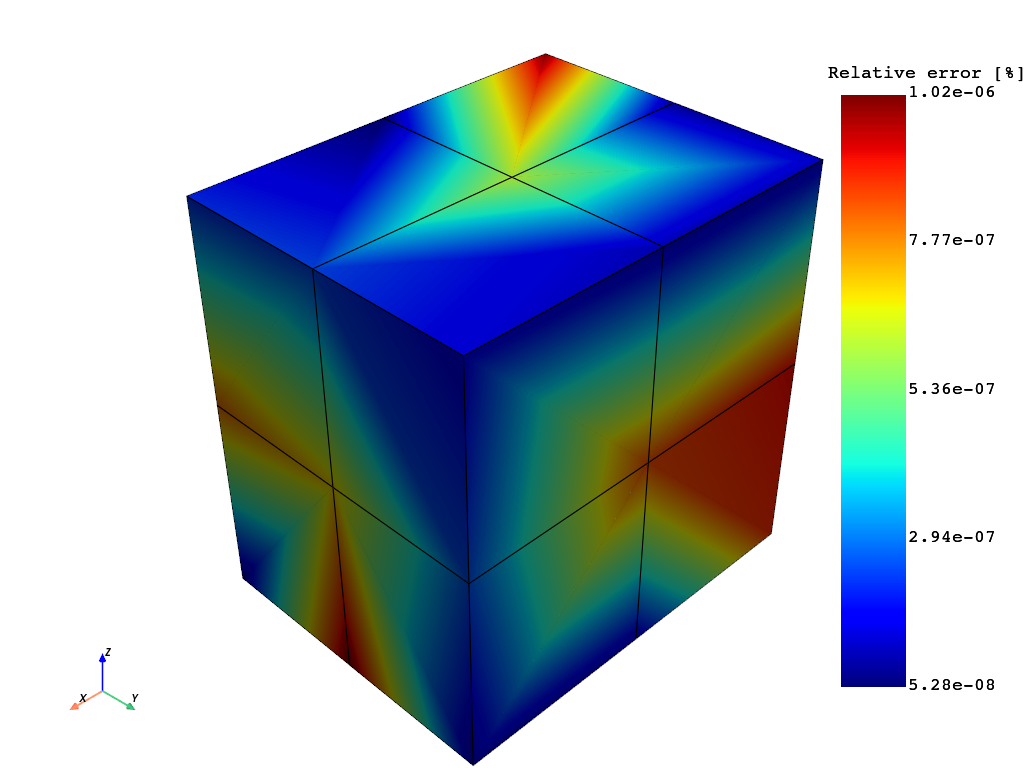

In [10]:
mesh.plot(abs_error.eval(), scalar_bar_args={"title": "Absolute error [mm]"})
mesh.plot(rel_error.eval(), scalar_bar_args={"title": "Relative error [%]"})